# RUSSET DETECTION 

Students should identify the russet or at least some part of it with no false positive areas (if possible), in order to correctly classify the two fruits.

Find a suitable (Mahalanobis) color distance. Other color spaces, e.g. HSV, HSL, LUV, should be tried.

In [1]:
from functions import *

#### Load the images

In [2]:
directory = 'fruit-inspection-images/second_task/'
img_color,img_gray = load_images(directory, [4,6],"HSV")

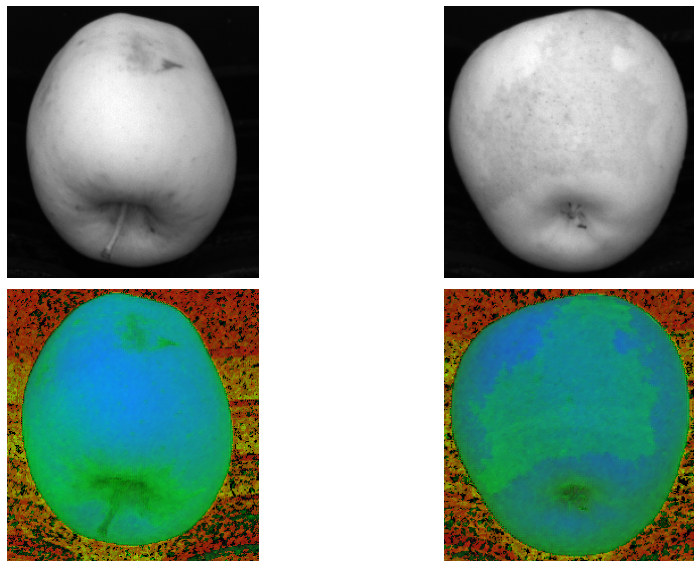

In [3]:
show_images(img_gray+ img_color,rows=2)


### Fruit Segmentation

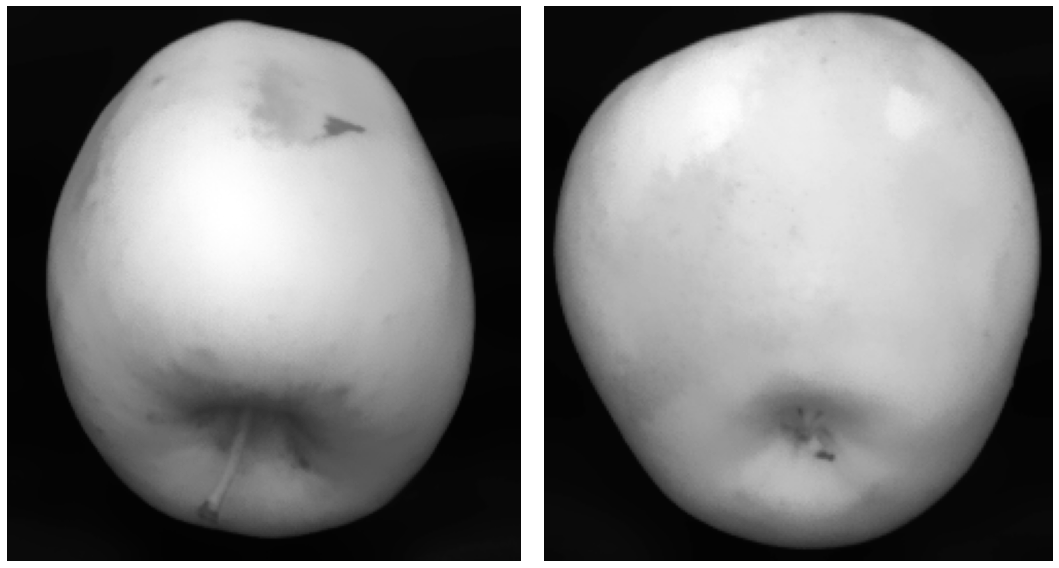

In [4]:
fruit_blurred=[]
for i in range(len(img_gray)):

    fruit_blurred.append(cv2.bilateralFilter(img_gray[i], 0, 10, 10))

show_images(fruit_blurred,rows=1)    

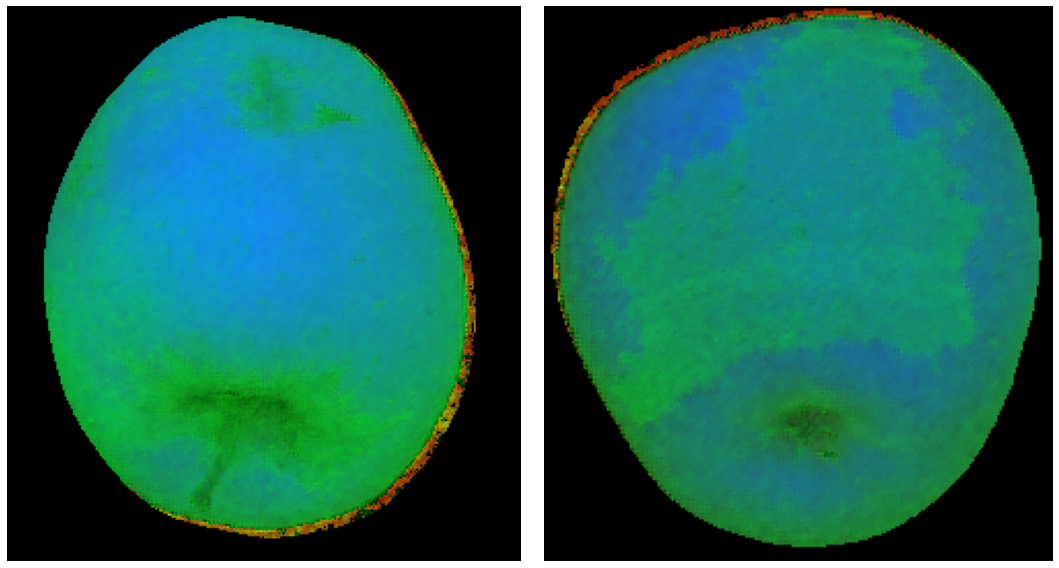

In [6]:
#First Phase 
fruits=[]
fruits_bw=[]
# Esegui una soglia per separare il frutto dallo sfondo
for i in range(len(fruit_blurred)):
    _, binary = cv2.threshold(img_gray[i], thresh_peaks(img_gray[i]), 255, cv2.THRESH_BINARY)

    fill= flood_fill(binary)
    fruits_bw.append(fill)
    fruits.append(cv2.bitwise_and(img_color[i],img_color[i],mask=fill))

show_images(fruits,rows=1)

### MAHALANOBIS DISTANCE - RGB
- mean as reference color from the russet examples
- covairiance matrix from the russet examples


In [7]:
samples=load_samples("fruit-inspection-images/second_task/samples",[1,11],"HSV")

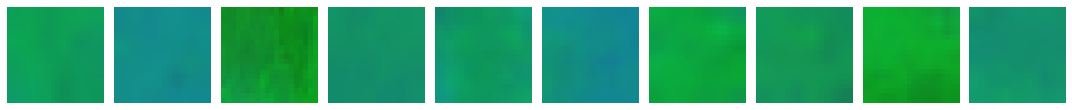

In [8]:
show_images(samples)

In [9]:
mean_color=reference_color(samples)
mean_color

array([ 15.91975, 149.85925,  91.1285 ])

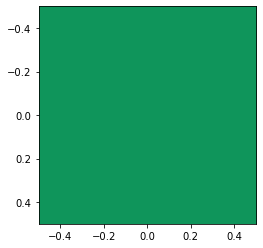

In [10]:
color_image = [[mean_color.astype(np.uint8)]]
plt.imshow(color_image)

In [11]:
iv_cov=inv_cov_matrix(samples)

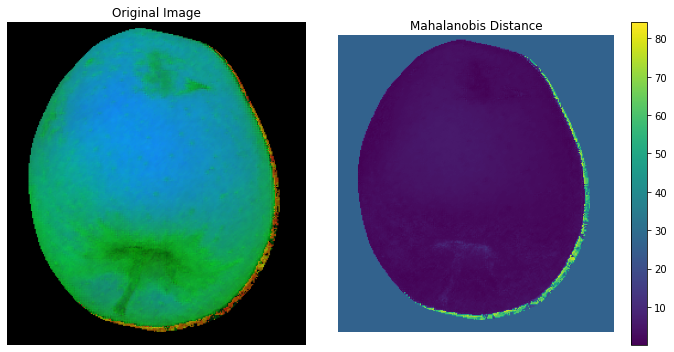

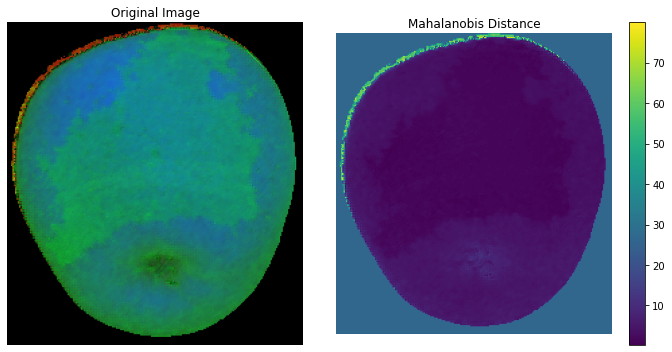

In [12]:
from scipy.spatial.distance import mahalanobis

distances=[]
for i in range(len(fruits)):
    image=fruits[i].copy()

    image_data = image.reshape(-1, 3)

    mahalanobis_distances = np.array([mahalanobis(pixel,mean_color,iv_cov) for pixel in image_data])
    mahalanobis_distances = mahalanobis_distances.reshape(image.shape[:2])

    min_distance = np.min(mahalanobis_distances)
    max_distance = np.max(mahalanobis_distances)
    normalized_distances = (mahalanobis_distances - min_distance) / (max_distance - min_distance)*255
    
    distances.append(normalized_distances.astype(np.uint8))
    #visualizzo il grafico della distanza di mahalanobis 
    show_mahalanobis_distance(fruits[i],mahalanobis_distances)

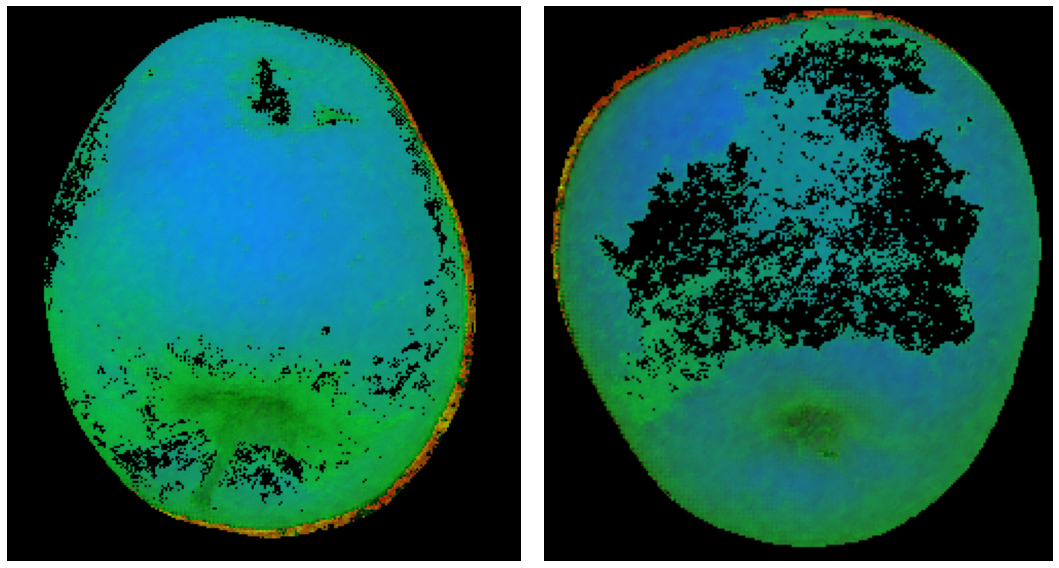

In [18]:
russet_detec=[]
maha_mask=[]
for i in range(len(distances)):
# Esegui la dilatazione
 
    _, black_mask =cv2.threshold(distances[i],3, 255,cv2.THRESH_BINARY)
    maha_mask.append(black_mask)
    russet_detec.append(cv2.bitwise_and(fruits[i], fruits[i], mask=black_mask))
#visualizzo le zone di russet sull'immagine originale
show_images(russet_detec, rows=1)

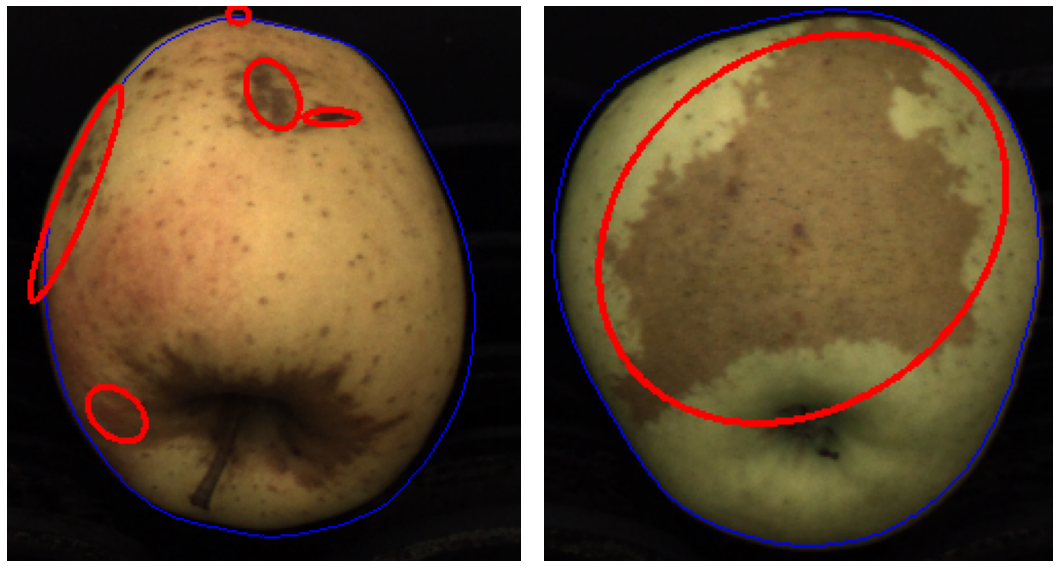

In [19]:
results=[]
edges=[]
for i in range(len(img_gray)):
    f_dis=cv2.cvtColor(fruits[i], cv2.COLOR_HSV2RGB)
    im_dis=cv2.cvtColor(img_color[i], cv2.COLOR_HSV2RGB)
    display, retval, labels = get_russet(im_dis, fruits_bw[i], maha_mask[i], im_dis)
    
    defects_counter = 0
    for j in range(1, retval):
        c = np.zeros_like(labels, dtype=np.uint8)
        c[labels == j] = 255
        defects_counter += draw_defects(display, c, 2, 1.1, 20, 100000)

    results.append(display)


show_images(results,rows=1)